### Deep Neural Network in TensorFlow

In the following, we'll use TensorFlow to classify the letters in the MNIST database. 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('.', one_hot=True, reshape=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting .\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting .\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting .\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting .\t10k-labels-idx1-ubyte.gz


### MNIST database
Let's inspect the data a bit

number of training point: 55000
shape of training data:   (55000, 28, 28, 1)
labels histogram


<Container object of 10 artists>

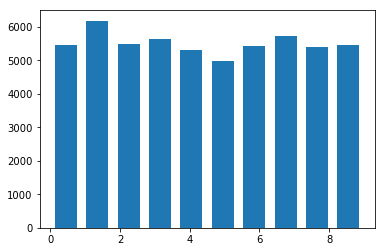

In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

print('number of training point:', mnist.train.num_examples)
print('shape of training data:  ', mnist.train.images.shape)
labels = np.argwhere(mnist.train.labels==1)[:,1]
hist, bins = np.histogram(labels, bins=10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
print('labels histogram')
plt.bar(center, hist, align='center', width=width)

### Learning parameters
We define some global parameters

In [134]:
import tensorflow as tf

# alway reset everything
tf.reset_default_graph()

# optimize parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 128
display_step = 1

n_input = 784     # 28 x 28 (img shape: 28 * 28 * 1)
n_classes = 10    # mnist it to classify 0->9

### Network parameters
We define some parameter/variables for our neural networks

In [135]:
n_hidden_layer = 256 # number of neuron in hidden layer

weights = {'hidden_layer' : tf.Variable(tf.random_normal([n_input, n_hidden_layer], name = 'W_0')),
           'out' : tf.Variable(tf.random_normal([n_hidden_layer, n_classes]), name = 'W_1')}

biases = {'hidden_layer' : tf.Variable(tf.random_normal([n_hidden_layer]), name = 'b_0'),
          'out' : tf.Variable(tf.random_normal([n_classes]), name = 'b_1')}

# we define input and flatten it
x = tf.placeholder('float', [None, 28,28,1], name = 'input_x')
y = tf.placeholder('float', [None, n_classes], name = 'target_y')
x_flat = tf.reshape(x,[-1, n_input], name = 'input_x_flat')

### Multilayer perceptron with ReLU
We define our layer with ReLU as following

In [136]:
# affine layer
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])

# relu layer
layer_1 = tf.nn.relu(layer_1)

# output layer
logits = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])

###  Loss function and Optimizer
The logists with be size of N x n_classes where N = number of samples and n_classes = 10. We need to define a loss function and choose an optimizer. We use the following loss $ L = \frac{1}{N}\sum L_i$ where $L_i$ is given by
$$L_i = \sum_{j=0}^{9}  -\log(\mathrm{logits}[i,j])\times y[i,j]$$

Regarding the optimizer, we use the simple Gradient Descent to minimize the loss

In [137]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

# we define accuracy to measure the performance
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Try it out
We are ready to run it and measure the performance inside each loop. After the model is trained, we save it to a file.

In [138]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)  # we need to run this to initialize all variables

# training loop
num_batch_per_epoch = int(mnist.train.num_examples/batch_size)

for epoch in range(training_epochs):
    for i in range(num_batch_per_epoch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)   # get batch sample
        sess.run(optimizer, feed_dict = {x : batch_x, y : batch_y})
    
    train_acc = sess.run(accuracy, feed_dict={x: mnist.train.images, y: mnist.train.labels})
    val_acc = sess.run(accuracy, feed_dict={x: mnist.validation.images, y: mnist.validation.labels})
    
    print('Epoch %3d train-acc %5.3f vs val-acc %5.3f' % (epoch, train_acc, val_acc))

save_file = './tf_mnist_trained/model.ckpt'
saver = tf.train.Saver()
saver.save(sess, save_file)

print('saved x:      {}'.format(x.name))
print('saved y:      {}'.format(y.name))
print('saved x_flat: {}'.format(x_flat.name))

Epoch   0 train-acc 0.378 vs val-acc 0.383
Epoch   1 train-acc 0.532 vs val-acc 0.538
Epoch   2 train-acc 0.611 vs val-acc 0.626
Epoch   3 train-acc 0.661 vs val-acc 0.677
Epoch   4 train-acc 0.692 vs val-acc 0.709
Epoch   5 train-acc 0.716 vs val-acc 0.729
Epoch   6 train-acc 0.735 vs val-acc 0.747
Epoch   7 train-acc 0.750 vs val-acc 0.760
Epoch   8 train-acc 0.762 vs val-acc 0.774
Epoch   9 train-acc 0.772 vs val-acc 0.782
saved x:      input_x:0
saved y:      target_y:0
saved x_flat: input_x_flat:0


### Measure the accuracy
We need to measure the accuracy in the separated test-set

In [130]:
print('Accuracy on test-set: %5.3f' % sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Accuracy on test-set: 0.783


### Load trained model
We can reload the model from file. Note that, we need to ensure the name is matched and we 

In [139]:
# reset everything
tf.reset_default_graph()

n_hidden_layer = 256 # number of neuron in hidden layer

weights = {'hidden_layer' : tf.Variable(tf.random_normal([n_input, n_hidden_layer], name = 'W_0')),
           'out' : tf.Variable(tf.random_normal([n_hidden_layer, n_classes]), name = 'W_1')}

biases = {'hidden_layer' : tf.Variable(tf.random_normal([n_hidden_layer]), name = 'b_0'),
          'out' : tf.Variable(tf.random_normal([n_classes]), name = 'b_1')}

# we define input and flatten it
x = tf.placeholder('float', [None, 28,28,1], name = 'input_x')
y = tf.placeholder('float', [None, n_classes], name = 'target_y')
x_flat = tf.reshape(x,[-1, n_input], name = 'input_x_flat')

print('name x:      {}'.format(x.name))
print('name y:      {}'.format(y.name))
print('name x_flat: {}'.format(x_flat.name))

# affine layer
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])

# relu layer
layer_1 = tf.nn.relu(layer_1)

# output layer
logits = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])

# we define accuracy to measure the performance
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)

    test_accuracy = sess.run(
        accuracy,
        feed_dict={x: mnist.test.images, y: mnist.test.labels})
    print('Test Accuracy: {}'.format(test_accuracy))

name x:      input_x:0
name y:      target_y:0
name x_flat: input_x_flat:0
Test Accuracy: 0.7825999855995178
